**Name:** Leung Wilson, Lee Wing Kei Winky

**EID:** wilsleung3, wkwlee3

**Kaggle Team Name:** Group_WW

# CS4487 - Course Project: Aerial Cactus Identification

## Goal
In this project, your goal is to train a classifier to predict whether an input image contains cactus.


## Methodology
You need to train classifiers using the training data, and then predict on the test data. You are free to choose the feature extraction method and classifier algorithm.  You are free to use methods that were not introduced in class.  You should probably do cross-validation to select a good parameters.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking.

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas.

**Note:** You can only submit 2 times per day to Kaggle!



## Kaggle Notebooks

You can use Kaggle notebooks to run your code. This ipynb has also been uploaded to the Kaggle competition site.

# Load the Data

The class labels `"1"` for images containing cactus and `"0"` for others.

To submit to Kaggle, you need to generate a Kaggle submission files, which is CSV file with the following format. `'id'` is the file name of the input image:

<pre>
Id,Prediction
cactus_0181_18.jpg,1
Sinplanta.4365.jpg,0
...
</pre>

Here are two helpful functions for reading the data and writing the Kaggle submission file.

In [ ]:
%matplotlib inline
import IPython.core.display
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from glob import glob
from scipy import stats
import csv
import os
random.seed(100)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [ ]:
def read_train_data():
    cactus_imgs = glob("training_set/training_set/cactus/*")
    cactus_labels = ones(len(cactus_imgs), dtype=int)
    nocactus_imgs = glob("training_set/training_set/no_cactus/*")
    nocactus_labels = zeros(len(nocactus_imgs), dtype=int)

    train_X = cactus_imgs + nocactus_imgs
    train_Y = hstack((cactus_labels, nocactus_labels))
    return train_X, train_Y

def read_test_data():
    return glob("validation_set/*/*/*")

def write_csv_kaggle_sub(fname, X, Y):
    # fname = file name
    # X is a list with image names
    # Y is a list/array with class entries

    # header
    tmp = [['Id', 'Prediction']]

    # add ID numbers for each Y
    for x,y in zip(X, Y):
        tmp2 = [x, y]
        tmp.append(tmp2)

    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

In [ ]:
train_X, train_Y = read_train_data()
print(train_X[0], train_Y[0])
print(train_X[15000], train_Y[15000])

test_X = read_test_data()
print(len(test_X))
print(os.path.basename(test_X[0]))

training_set/training_set/cactus/cactus_0028_0.jpg 1
training_set/training_set/no_cactus/Sinplanta.2677.jpg 0
4000
cactus_0181_18.jpg


Here is an example to write a csv file with predictions on the test set.  These are random predictions.

In [ ]:
# write your predictions on the test set
dummy_test_X = [os.path.basename(x) for x in test_X]
test_Y = random.randint(2, size=len(test_X))

write_csv_kaggle_sub("my_submission.csv", dummy_test_X, test_Y)

# YOUR CODE and DOCUMENTATION HERE

In [ ]:
print("Number of images in training set: %s \n" % len(train_X))
print("class 1 (cactus): %s" % sum(train_Y))
print("class 0 (no_cactus): %s" % sum(1-train_Y))

Number of images in training set: 17500 

class 1 (cactus): 13136
class 0 (no_cactus): 4364


We can see that the dataset is very unbalanced. The problem will be discussed later in section 4.

# 1. Data Augmentation and Pipeline
We choose to import data by flow_from_directory.
<br> Since the images are in different size, we first need to resize the images and also preprocessing (like normalization) by Keras ImageDataGenerator.
<br> The training set is also split into training set (75%) and validation set (25%) to create a pipeline.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

traindata_gen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.25)

testdata_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = traindata_gen.flow_from_directory(
    'training_set/training_set/',
    target_size = (32,32),
    batch_size=64,
    shuffle=True,
    color_mode="rgb",
    class_mode = 'binary',
    subset='training'
)

valid_gen = traindata_gen.flow_from_directory(
    'training_set/training_set/',
    target_size = (32,32),
    batch_size=64,
    shuffle=True,
    color_mode="rgb",
    class_mode = 'binary',
    subset='validation'
)

test_gen = testdata_gen.flow_from_directory(
    'validation_set/validation_set/',
    target_size=(32,32),
    batch_size=64,
    shuffle=False,
    color_mode="rgb",
    class_mode = 'binary'
)

Found 13125 images belonging to 2 classes.
Found 4375 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


# 2. Building and Training a Convolutional Network (CNN)
A CNN is built with some callbacks that can help to improve the model.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.losses import binary_crossentropy

model = Sequential()
model.add(Conv2D(32, (3, 3),
                 input_shape=(32,32,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0

In [ ]:
#callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    min_delta=0.001,
    mode='min',
    verbose=1
)

checkpoint_path = 'model.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_freq='epoch',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=0.0001,
    cooldown=1,
    mode='min',
    verbose=1
)

In [ ]:
hist = model.fit_generator(generator=train_gen,
                           steps_per_epoch=len(train_gen)//train_gen.batch_size,
                           epochs=500,
                           validation_data=valid_gen,
                           validation_steps=len(valid_gen)//valid_gen.batch_size,
                           verbose=2,
                           callbacks=[early_stopping, checkpoint, reduce_lr]
                          )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500

Epoch 00001: val_loss improved from inf to 0.57970, saving model to model.hdf5
3/3 - 1s - loss: 0.6429 - accuracy: 0.6042 - val_loss: 0.5797 - val_accuracy: 0.7500
Epoch 2/500

Epoch 00002: val_loss improved from 0.57970 to 0.48896, saving model to model.hdf5
3/3 - 1s - loss: 0.5876 - accuracy: 0.7552 - val_loss: 0.4890 - val_accuracy: 0.8438
Epoch 3/500

Epoch 00003: val_loss did not improve from 0.48896
3/3 - 1s - loss: 0.5851 - accuracy: 0.7083 - val_loss: 0.5862 - val_accuracy: 0.7656
Epoch 4/500

Epoch 00004: val_loss did not improve from 0.48896
3/3 - 1s - loss: 0.5462 - accuracy: 0.7396 - val_loss: 0.5884 - val_accuracy: 0.7031
Epoch 5/500

Epoch 00005: val_loss improved from 0.48896 to 0.47153, saving model to model.hdf5
3/3 - 1s - loss: 0.5332 - accuracy: 0.7500 - val_loss: 0.4715 - val_accuracy: 0.8125
Epoch 6/500

Epoch 00006: val_loss did not improve from 0.47153
3/3 - 1s - loss: 0.5259

Epoch 51/500

Epoch 00051: val_loss did not improve from 0.30110
3/3 - 1s - loss: 0.2204 - accuracy: 0.9167 - val_loss: 0.3511 - val_accuracy: 0.8594
Epoch 52/500

Epoch 00052: val_loss did not improve from 0.30110
3/3 - 0s - loss: 0.2758 - accuracy: 0.9062 - val_loss: 0.4685 - val_accuracy: 0.7500
Epoch 53/500

Epoch 00053: val_loss did not improve from 0.30110
3/3 - 1s - loss: 0.2293 - accuracy: 0.9427 - val_loss: 0.5064 - val_accuracy: 0.6875
Epoch 54/500

Epoch 00054: val_loss did not improve from 0.30110
3/3 - 1s - loss: 0.2090 - accuracy: 0.9375 - val_loss: 0.5250 - val_accuracy: 0.7188
Epoch 55/500

Epoch 00055: val_loss did not improve from 0.30110
3/3 - 0s - loss: 0.1832 - accuracy: 0.9531 - val_loss: 0.4043 - val_accuracy: 0.7656
Epoch 56/500

Epoch 00056: val_loss did not improve from 0.30110
3/3 - 0s - loss: 0.2182 - accuracy: 0.9271 - val_loss: 0.3939 - val_accuracy: 0.7656
Epoch 57/500

Epoch 00057: val_loss did not improve from 0.30110
3/3 - 0s - loss: 0.3066 - accuracy:

Epoch 106/500

Epoch 00106: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.1636 - accuracy: 0.9531 - val_loss: 0.7912 - val_accuracy: 0.5781
Epoch 107/500

Epoch 00107: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.2002 - accuracy: 0.9479 - val_loss: 0.6317 - val_accuracy: 0.7344
Epoch 108/500

Epoch 00108: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.2209 - accuracy: 0.9323 - val_loss: 0.5187 - val_accuracy: 0.7812
Epoch 109/500

Epoch 00109: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.2241 - accuracy: 0.9167 - val_loss: 0.6556 - val_accuracy: 0.7031
Epoch 110/500

Epoch 00110: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.1841 - accuracy: 0.9427 - val_loss: 0.5261 - val_accuracy: 0.7188
Epoch 111/500

Epoch 00111: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.1462 - accuracy: 0.9531 - val_loss: 0.4791 - val_accuracy: 0.7500
Epoch 112/500

Epoch 00112: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.2257 - ac

Epoch 161/500

Epoch 00161: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.2020 - accuracy: 0.9271 - val_loss: 0.5309 - val_accuracy: 0.7500
Epoch 162/500

Epoch 00162: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.2163 - accuracy: 0.9375 - val_loss: 0.4786 - val_accuracy: 0.7656
Epoch 163/500

Epoch 00163: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.2613 - accuracy: 0.9115 - val_loss: 0.4228 - val_accuracy: 0.8750
Epoch 164/500

Epoch 00164: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.1721 - accuracy: 0.9531 - val_loss: 0.4514 - val_accuracy: 0.7969
Epoch 165/500

Epoch 00165: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.2918 - accuracy: 0.9115 - val_loss: 0.6480 - val_accuracy: 0.7031
Epoch 166/500

Epoch 00166: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.1867 - accuracy: 0.9115 - val_loss: 0.5289 - val_accuracy: 0.7188
Epoch 167/500

Epoch 00167: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.1241 - ac

# 3. Preliminary Results

In [ ]:
acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']

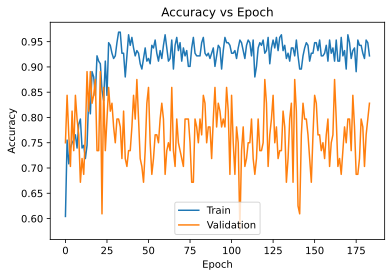

In [ ]:
# Trend of accuracy during the training
plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

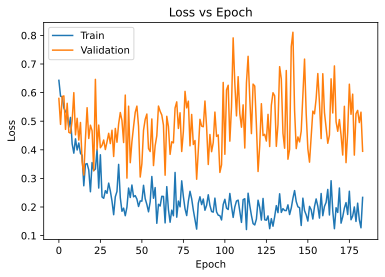

In [ ]:
# Trend of loss during the training
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

In [ ]:
print('Final validation loss and accuracy:')
model.load_weights(checkpoint_path)
model.evaluate_generator(generator=valid_gen,
                         steps=valid_gen.n//valid_gen.batch_size)

Final validation loss and accuracy:
Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.4512712359428406, 0.7954963445663452]

In [ ]:
print('Test loss and accuracy:')
model.load_weights(checkpoint_path)
model.evaluate_generator(generator=test_gen,
                         steps=test_gen.n//test_gen.batch_size)

Test loss and accuracy:


[0.29105547070503235, 0.9017137289047241]

Confusion Matrix (RGB image)


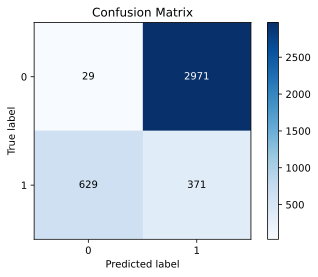

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(test_gen, steps=test_gen.n//test_gen.batch_size+1)
y_pred = 1-np.round(Y_pred)

print('Confusion Matrix (RGB image)')
cm = skplt.metrics.plot_confusion_matrix(test_gen.classes, y_pred)
plt.show()

# 4. Further Adjustment
## Image on grayscale
This time, we try to make the images from rgb into grayscale, and see if there is any improvement.

In [ ]:
gtrain_gen = traindata_gen.flow_from_directory(
    'training_set/training_set/',
    target_size = (32,32),
    batch_size=64,
    shuffle=True,
    color_mode="grayscale",
    class_mode = 'binary',
    subset='training'
)

gvalid_gen = traindata_gen.flow_from_directory(
    'training_set/training_set/',
    target_size = (32,32),
    batch_size=64,
    shuffle=True,
    color_mode="grayscale",
    class_mode = 'binary',
    subset='validation'
)

gtest_gen = testdata_gen.flow_from_directory(
    'validation_set/validation_set/',
    target_size=(32,32),
    batch_size=64,
    shuffle=False,
    color_mode="grayscale",
    class_mode = 'binary'
)

Found 13125 images belonging to 2 classes.
Found 4375 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.losses import binary_crossentropy

gmodel = Sequential()
gmodel.add(Conv2D(32, (3, 3),
                 input_shape=(32,32,1),
                 activation='relu'))
gmodel.add(MaxPooling2D(pool_size=(2, 2)))

gmodel.add(Conv2D(64, (3, 3), activation='relu'))
gmodel.add(MaxPooling2D(pool_size=(2, 2)))
gmodel.add(Dropout(0.2))

gmodel.add(Conv2D(128, (3, 3), activation='relu'))
gmodel.add(MaxPooling2D(pool_size=(2, 2)))
gmodel.add(Dropout(0.2))

gmodel.add(Flatten())
gmodel.add(Dense(128, activation='relu'))
gmodel.add(Dropout(0.5))
gmodel.add(Dense(1, activation='sigmoid'))

gmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

gmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 128)        

In [ ]:
ghist = gmodel.fit_generator(generator=gtrain_gen,
                    steps_per_epoch=len(gtrain_gen)//gtrain_gen.batch_size,
                    epochs=500,
                    validation_data=gvalid_gen,
                    validation_steps=len(gvalid_gen)//gvalid_gen.batch_size,
                    verbose=2,
                    callbacks=[early_stopping, checkpoint, reduce_lr]
                    )

Epoch 1/500

Epoch 00001: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.6552 - accuracy: 0.6198 - val_loss: 0.6072 - val_accuracy: 0.7344
Epoch 2/500

Epoch 00002: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.5698 - accuracy: 0.7292 - val_loss: 0.6132 - val_accuracy: 0.7344
Epoch 3/500

Epoch 00003: val_loss did not improve from 0.29713
3/3 - 1s - loss: 0.5829 - accuracy: 0.7344 - val_loss: 0.5711 - val_accuracy: 0.7344
Epoch 4/500

Epoch 00004: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.5551 - accuracy: 0.7552 - val_loss: 0.5930 - val_accuracy: 0.7188
Epoch 5/500

Epoch 00005: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.5148 - accuracy: 0.7656 - val_loss: 0.4963 - val_accuracy: 0.7969
Epoch 6/500

Epoch 00006: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.5388 - accuracy: 0.7396 - val_loss: 0.4779 - val_accuracy: 0.7969
Epoch 7/500

Epoch 00007: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.5293 - accuracy: 0.7448

Epoch 55/500

Epoch 00055: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.3451 - accuracy: 0.8802 - val_loss: 0.4806 - val_accuracy: 0.7969
Epoch 56/500

Epoch 00056: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.3669 - accuracy: 0.8490 - val_loss: 0.4473 - val_accuracy: 0.8281
Epoch 57/500

Epoch 00057: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.3030 - accuracy: 0.9375 - val_loss: 0.3733 - val_accuracy: 0.8750
Epoch 58/500

Epoch 00058: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.3800 - accuracy: 0.8646 - val_loss: 0.3678 - val_accuracy: 0.8438
Epoch 59/500

Epoch 00059: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.3417 - accuracy: 0.8947 - val_loss: 0.3943 - val_accuracy: 0.8438
Epoch 60/500

Epoch 00060: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.4106 - accuracy: 0.8229 - val_loss: 0.4848 - val_accuracy: 0.8125
Epoch 61/500

Epoch 00061: val_loss did not improve from 0.29713
3/3 - 0s - loss: 0.3120 - accuracy:

Epoch 110/500

Epoch 00110: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3180 - accuracy: 0.8698 - val_loss: 0.4896 - val_accuracy: 0.7812
Epoch 111/500

Epoch 00111: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3925 - accuracy: 0.8438 - val_loss: 0.4114 - val_accuracy: 0.8594
Epoch 112/500

Epoch 00112: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3350 - accuracy: 0.8594 - val_loss: 0.4192 - val_accuracy: 0.7969
Epoch 113/500

Epoch 00113: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3298 - accuracy: 0.9010 - val_loss: 0.3607 - val_accuracy: 0.8281
Epoch 114/500

Epoch 00114: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3921 - accuracy: 0.8542 - val_loss: 0.3094 - val_accuracy: 0.8750
Epoch 115/500

Epoch 00115: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3697 - accuracy: 0.8385 - val_loss: 0.3725 - val_accuracy: 0.8125
Epoch 116/500

Epoch 00116: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3926 - ac

Epoch 165/500

Epoch 00165: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.2348 - accuracy: 0.9115 - val_loss: 0.4866 - val_accuracy: 0.7812
Epoch 166/500

Epoch 00166: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3510 - accuracy: 0.8854 - val_loss: 0.3961 - val_accuracy: 0.8125
Epoch 167/500

Epoch 00167: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.2651 - accuracy: 0.9062 - val_loss: 0.4543 - val_accuracy: 0.7656
Epoch 168/500

Epoch 00168: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.2829 - accuracy: 0.8802 - val_loss: 0.4528 - val_accuracy: 0.7812
Epoch 169/500

Epoch 00169: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3082 - accuracy: 0.8646 - val_loss: 0.3588 - val_accuracy: 0.8125
Epoch 170/500

Epoch 00170: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3364 - accuracy: 0.8646 - val_loss: 0.3849 - val_accuracy: 0.8594
Epoch 171/500

Epoch 00171: val_loss did not improve from 0.22572
3/3 - 0s - loss: 0.3062 - ac

In [ ]:
acc=ghist.history['accuracy']
val_acc=ghist.history['val_accuracy']
loss=ghist.history['loss']
val_loss=ghist.history['val_loss']

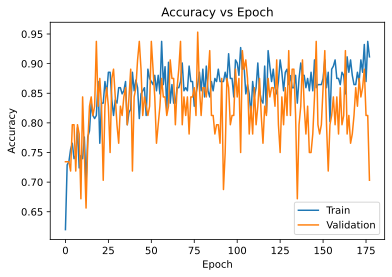

In [ ]:
# Trend of accuracy during the training
plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

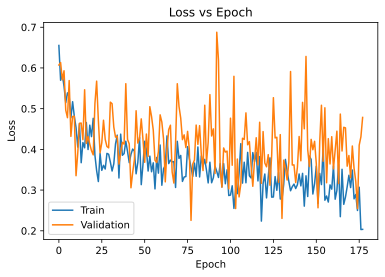

In [ ]:
# Trend of loss during the training
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

In [ ]:
print('Final validation loss and accuracy:')
gmodel.load_weights(checkpoint_path)
gmodel.evaluate_generator(generator=gvalid_gen,
                         steps=gvalid_gen.n//gvalid_gen.batch_size)

Final validation loss and accuracy:


[0.4285336434841156, 0.8265165686607361]

In [ ]:
print('Test loss and accuracy:')
gmodel.load_weights(checkpoint_path)
gmodel.evaluate_generator(generator=gtest_gen,
                         steps=gtest_gen.n//gtest_gen.batch_size)

Test loss and accuracy:


[0.35367056727409363, 0.8671875]

Confusion Matrix (Grayscale image)


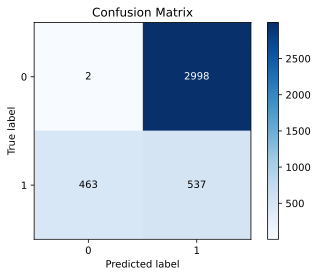

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = gmodel.predict(gtest_gen, steps=gtest_gen.n//gtest_gen.batch_size+1)
y_pred = 1-np.round(Y_pred)

print('Confusion Matrix (Grayscale image)')
cm = skplt.metrics.plot_confusion_matrix(gtest_gen.classes, y_pred)
plt.show()

## Small Summary
The model seems overfit under grayscale images, as all images includes cactus is correctly classified, but most of the images that does not have cactus is not correctly classified.

## Put class weight into consideration
Since in the training set, there are 75% cactus image and 25% non-cactus image.
We hope to make equal class proportion for model training so the model would be less bias.

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_gen.classes),
                train_gen.classes)
class_weights = {i : class_weights[i] for i in range(2)}
print(class_weights)

{0: 0.6661084043848965, 1: 2.0050412465627865}


/opt/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [ ]:
#callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    min_delta=0.001,
    mode='min',
    verbose=1
)

checkpoint_path = 'weightmodel.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_freq='epoch',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=0.0001,
    cooldown=1,
    mode='min',
    verbose=1
)

In [ ]:
hist = model.fit_generator(generator=train_gen,
                           class_weight=class_weights,
                           steps_per_epoch=len(train_gen)//train_gen.batch_size,
                           epochs=500,
                           validation_data=valid_gen,
                           validation_steps=len(valid_gen)//valid_gen.batch_size,
                           verbose=2,
                           callbacks=[early_stopping, checkpoint, reduce_lr]
                          )

Epoch 1/500

Epoch 00001: val_loss improved from inf to 0.44212, saving model to weightmodel.hdf5
3/3 - 1s - loss: 0.4221 - accuracy: 0.9323 - val_loss: 0.4421 - val_accuracy: 0.7656
Epoch 2/500

Epoch 00002: val_loss did not improve from 0.44212
3/3 - 1s - loss: 0.3633 - accuracy: 0.9115 - val_loss: 0.5091 - val_accuracy: 0.7344
Epoch 3/500

Epoch 00003: val_loss did not improve from 0.44212
3/3 - 0s - loss: 0.2753 - accuracy: 0.8542 - val_loss: 0.9029 - val_accuracy: 0.5312
Epoch 4/500

Epoch 00004: val_loss did not improve from 0.44212
3/3 - 1s - loss: 0.2406 - accuracy: 0.9219 - val_loss: 0.6619 - val_accuracy: 0.6406
Epoch 5/500

Epoch 00005: val_loss did not improve from 0.44212
3/3 - 0s - loss: 0.3267 - accuracy: 0.8490 - val_loss: 0.5767 - val_accuracy: 0.7188
Epoch 6/500

Epoch 00006: val_loss improved from 0.44212 to 0.36917, saving model to weightmodel.hdf5
3/3 - 1s - loss: 0.2496 - accuracy: 0.9167 - val_loss: 0.3692 - val_accuracy: 0.8594
Epoch 7/500

Epoch 00007: val_loss

Epoch 56/500

Epoch 00056: val_loss did not improve from 0.36917
3/3 - 0s - loss: 0.2325 - accuracy: 0.9062 - val_loss: 0.8004 - val_accuracy: 0.6406
Epoch 57/500

Epoch 00057: val_loss did not improve from 0.36917
3/3 - 1s - loss: 0.1913 - accuracy: 0.9062 - val_loss: 0.6430 - val_accuracy: 0.7031
Epoch 58/500

Epoch 00058: val_loss did not improve from 0.36917
3/3 - 1s - loss: 0.2181 - accuracy: 0.9323 - val_loss: 0.3763 - val_accuracy: 0.8438
Epoch 59/500

Epoch 00059: val_loss did not improve from 0.36917
3/3 - 1s - loss: 0.2886 - accuracy: 0.9010 - val_loss: 0.7066 - val_accuracy: 0.7188
Epoch 60/500

Epoch 00060: val_loss did not improve from 0.36917
3/3 - 0s - loss: 0.2384 - accuracy: 0.9323 - val_loss: 0.5675 - val_accuracy: 0.7031
Epoch 61/500

Epoch 00061: val_loss did not improve from 0.36917
3/3 - 1s - loss: 0.2540 - accuracy: 0.8854 - val_loss: 1.0289 - val_accuracy: 0.5625
Epoch 62/500

Epoch 00062: val_loss did not improve from 0.36917
3/3 - 1s - loss: 0.1980 - accuracy:

In [ ]:
print('Final validation loss and accuracy:')
model.load_weights(checkpoint_path)
model.evaluate_generator(generator=valid_gen,
                         steps=valid_gen.n//valid_gen.batch_size)

Final validation loss and accuracy:


[0.5605501532554626, 0.7231158018112183]

In [ ]:
print('Test loss and accuracy:')
model.load_weights(checkpoint_path)
model.evaluate_generator(generator=test_gen,
                         steps=test_gen.n//test_gen.batch_size)

Test loss and accuracy:


[0.21575745940208435, 0.922631025314331]

Confusion Matrix (RGB image with class weight)


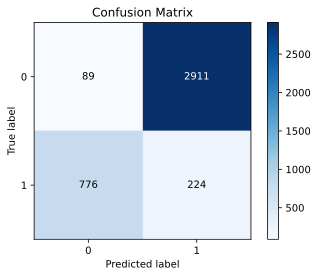

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(test_gen, steps=test_gen.n//test_gen.batch_size+1)
y_pred = 1-np.round(Y_pred)

print('Confusion Matrix (RGB image with class weight)')
cm = skplt.metrics.plot_confusion_matrix(gtest_gen.classes, y_pred)
plt.show()

In [ ]:
####save csv (can del later)
#test_X = [os.path.basename(x) for x in test_X]
#Y_pred = model.predict(test_gen, steps=test_gen.n//test_gen.batch_size+1)
#y_pred = 1-(np.round(Y_pred).astype(int))
#test_Y = y_pred.flatten()

#write_csv_kaggle_sub("55219652_55778369_submission.csv", test_X, test_Y)

In [ ]:
hist = gmodel.fit_generator(generator=gtrain_gen,
                           class_weight=class_weights,
                           steps_per_epoch=len(gtrain_gen)//gtrain_gen.batch_size,
                           epochs=500,
                           validation_data=gvalid_gen,
                           validation_steps=len(gvalid_gen)//gvalid_gen.batch_size,
                           verbose=2,
                           callbacks=[early_stopping, checkpoint, reduce_lr]
                          )

Epoch 1/500

Epoch 00001: val_loss did not improve from 0.36917
3/3 - 1s - loss: 0.4486 - accuracy: 0.9062 - val_loss: 0.4442 - val_accuracy: 0.7656
Epoch 2/500

Epoch 00002: val_loss did not improve from 0.36917
3/3 - 0s - loss: 0.3960 - accuracy: 0.9062 - val_loss: 0.4836 - val_accuracy: 0.7656
Epoch 3/500

Epoch 00003: val_loss did not improve from 0.36917
3/3 - 0s - loss: 0.5013 - accuracy: 0.8854 - val_loss: 0.5813 - val_accuracy: 0.7969
Epoch 4/500

Epoch 00004: val_loss did not improve from 0.36917
3/3 - 0s - loss: 0.4371 - accuracy: 0.8698 - val_loss: 0.4540 - val_accuracy: 0.8125
Epoch 5/500

Epoch 00005: val_loss did not improve from 0.36917
3/3 - 0s - loss: 0.4255 - accuracy: 0.8646 - val_loss: 0.4727 - val_accuracy: 0.7969
Epoch 6/500

Epoch 00006: val_loss did not improve from 0.36917
3/3 - 0s - loss: 0.5028 - accuracy: 0.8281 - val_loss: 0.4808 - val_accuracy: 0.7656
Epoch 7/500

Epoch 00007: val_loss did not improve from 0.36917
3/3 - 0s - loss: 0.4877 - accuracy: 0.8177

Epoch 56/500

Epoch 00056: val_loss did not improve from 0.35308
3/3 - 0s - loss: 0.4274 - accuracy: 0.7448 - val_loss: 0.5987 - val_accuracy: 0.6250
Epoch 57/500

Epoch 00057: val_loss did not improve from 0.35308
3/3 - 0s - loss: 0.3351 - accuracy: 0.8229 - val_loss: 0.5355 - val_accuracy: 0.6875
Epoch 58/500

Epoch 00058: val_loss did not improve from 0.35308
3/3 - 0s - loss: 0.3643 - accuracy: 0.8281 - val_loss: 0.4122 - val_accuracy: 0.8281
Epoch 59/500

Epoch 00059: val_loss did not improve from 0.35308
3/3 - 0s - loss: 0.3940 - accuracy: 0.8438 - val_loss: 0.3816 - val_accuracy: 0.7969
Epoch 60/500

Epoch 00060: val_loss did not improve from 0.35308
3/3 - 0s - loss: 0.5763 - accuracy: 0.7969 - val_loss: 0.5236 - val_accuracy: 0.7656
Epoch 61/500

Epoch 00061: val_loss did not improve from 0.35308
3/3 - 0s - loss: 0.3958 - accuracy: 0.8385 - val_loss: 0.4940 - val_accuracy: 0.6719
Epoch 62/500

Epoch 00062: val_loss did not improve from 0.35308
3/3 - 0s - loss: 0.4757 - accuracy:

Epoch 111/500

Epoch 00111: val_loss did not improve from 0.35308
3/3 - 0s - loss: 0.3714 - accuracy: 0.8333 - val_loss: 0.5388 - val_accuracy: 0.7031
Epoch 112/500

Epoch 00112: val_loss improved from 0.35308 to 0.30793, saving model to weightmodel.hdf5
3/3 - 0s - loss: 0.3795 - accuracy: 0.8177 - val_loss: 0.3079 - val_accuracy: 0.8750
Epoch 113/500

Epoch 00113: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.3678 - accuracy: 0.8906 - val_loss: 0.5176 - val_accuracy: 0.6562
Epoch 114/500

Epoch 00114: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.3432 - accuracy: 0.8646 - val_loss: 0.4708 - val_accuracy: 0.7344
Epoch 115/500

Epoch 00115: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.3903 - accuracy: 0.8333 - val_loss: 0.6383 - val_accuracy: 0.6250
Epoch 116/500

Epoch 00116: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.4858 - accuracy: 0.7917 - val_loss: 0.6051 - val_accuracy: 0.6406
Epoch 117/500

Epoch 00117: val_loss did not improve fro


Epoch 00165: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.3327 - accuracy: 0.9219 - val_loss: 0.4088 - val_accuracy: 0.7812
Epoch 166/500

Epoch 00166: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.4381 - accuracy: 0.8698 - val_loss: 0.5174 - val_accuracy: 0.7500
Epoch 167/500

Epoch 00167: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.3439 - accuracy: 0.9010 - val_loss: 0.4894 - val_accuracy: 0.7656
Epoch 168/500

Epoch 00168: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.3363 - accuracy: 0.8646 - val_loss: 0.5973 - val_accuracy: 0.6719
Epoch 169/500

Epoch 00169: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.3900 - accuracy: 0.7812 - val_loss: 0.5654 - val_accuracy: 0.7031
Epoch 170/500

Epoch 00170: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.4040 - accuracy: 0.7812 - val_loss: 0.5838 - val_accuracy: 0.7031
Epoch 171/500

Epoch 00171: val_loss did not improve from 0.30793
3/3 - 0s - loss: 0.3203 - accuracy: 0.8333

In [ ]:
print('Final validation loss and accuracy:')
gmodel.load_weights(checkpoint_path)
gmodel.evaluate_generator(generator=gvalid_gen,
                         steps=gvalid_gen.n//gvalid_gen.batch_size)

Final validation loss and accuracy:


[0.438809871673584, 0.7837775945663452]

In [ ]:
print('Test loss and accuracy:')
gmodel.load_weights(checkpoint_path)
gmodel.evaluate_generator(generator=gtest_gen,
                         steps=gtest_gen.n//gtest_gen.batch_size)

Test loss and accuracy:


[0.27670830488204956, 0.8944052457809448]

Confusion Matrix (Grayscale image with class weight)


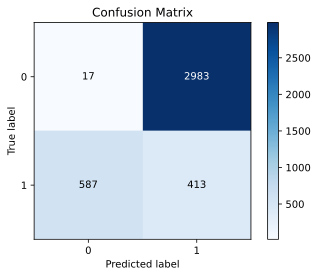

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = gmodel.predict(gtest_gen, steps=gtest_gen.n//gtest_gen.batch_size+1)
y_pred = 1-np.round(Y_pred)

print('Confusion Matrix (Grayscale image with class weight)')
cm = skplt.metrics.plot_confusion_matrix(gtest_gen.classes, y_pred)
plt.show()

# 5. Conclusion and Discussion
After applying class weight to the model, the accuracy of predicted results has increase.
<br> Models trained with images under RGB mode perform better than the grayscale images.
<br>

In the future, we may preprocess the dataset by oversampling or undersampling so to make the model learn rather than guessing for the minority class.
Also, we may try more complex CNN such as VGG-16 and Resnet50 that may achieve better results.